In [1]:
import matplotlib
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import pystan
# import corner
from scipy.interpolate import interp1d
from collections import OrderedDict
import pandas as pd
import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/maxisi/custompy3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Settings

## Plotting

In [2]:
# make plots to fit the LaTex column size but rescale them for ease of display here
scale_factor = 4

fig_width_pt = scale_factor*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_ratio = (np.sqrt(5)-1.0)/2.0         # Plot aspect ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*fig_ratio       # height in inches
fig_size = [fig_width, fig_height]

# LaTex text font sizse in points (rescaled as above)
fs = scale_factor*8  # general
lfs = 0.9*fs  # legend
tfs0 = 0.8*fs  # ax0 ticks
tfs12 = 0.6*fs # ax1/2 ticks

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.size': fs,
    'font.serif': 'Computer Modern Roman',
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
}
matplotlib.rcParams.update(mplparams)

# sns.set(font_scale=1.5)
sns.axes_style("white")
sns.set_style("ticks", {'font.family': 'serif'})

## Utilities

In [3]:
def snr_pdf(snr):
    """Distribution of SNRs, i.e. PDF(snr)"""
    return 3.*12.**3/snr**4

def gaussian(x, mean, sigma):
    """Gaussian PDF(x | mu, sigma)"""
    return 1./sqrt(2.*pi)/sigma*exp(-(x-mean)**2/2./sigma**2)

In [4]:
def MakeSNRPopulation(Ndet, seed, snr_min=12., snr_max=1000.):
    """Draw `Ndet` SNRs from SNR PDF using rejection sampling.
    """
    np.random.seed(seed)
    snr_sample_list = []
    for i in range(Ndet):
        snr_sample = 10000.
        # rejection sampling
        while snr_pdf(snr_sample) < np.random.uniform(0, 0.25):
            snr_sample = np.random.uniform(snr_min, snr_max)
        snr_sample_list.append(snr_sample)
    return np.array(snr_sample_list)

In [5]:
# # The above function draws samples from the SNR distribution.

# snr_x = np.linspace(12, 50, 100)
# plt.plot(snr_x, snr_pdf(snr_x))    
# plt.hist(MakeSNRPopulation(1000, 123), bins=100, normed=True) 
# plt.xlabel('SNR')
# plt.ylabel('PDF')
# plt.show()

In [6]:
def MakePhiPopulation(Ndet, seed, sigma_refs=[0.1, 0.5, 0.25], snr_ref=25., scale_factor=1., **kwargs):
    """Simulate a population of phi measurements from `Ndet` detections.
    
    Arguments
    ---------
    Ndet: int
        number of detections
    seed: float
        random seed
    sigma_refs: list
        list of reference sigmas for each phi
    snr_ref: float
        SNR of reference event (def. 25 for GW150914)
    scale_factor: float
        scale of sigma scatter to account for non-indep parameters (def. 1) 
    """
    # draw SNR
    SNR = MakeSNRPopulation(Ndet, seed, **kwargs)
    # create measured standard deviations for each phi
    sigma_m = [sigma_ref*snr_ref/SNR for sigma_ref in sigma_refs]
    # create measured mean for each phi
    sigma_m_scatter = [scale_factor*sm for sm in sigma_m]
    phis_m = [np.random.normal(0, sms) for sms in sigma_m_scatter]
    return phis_m, sigma_m

# Fit

Load reference $\sigma$'s from GW150914 posteriors.

In [7]:
# PPE parameters to load
params = ['dchi%i' % n for n in range(3)]
# reference event
event = '150914'

sigma_ref_dict = OrderedDict({})
for param in params:
    label = param.replace('dchi', r'$\delta\varphi_{')+'}$'
    fname = "data/TIGER_posterior_samples/posterior_gw%s_%s.dat" % (event, param)
    df = pd.read_csv(fname, sep='\t')
    sigma_ref_dict[label] = np.std(df[param])

Sample:

In [8]:
LOAD = True

In [9]:
if not LOAD:
    model_GR = pystan.StanModel(file='GR_model.stan')

In [10]:
# number of detections per set
dn = 5
Ndet_plot = np.arange(10, 100+dn, dn)
# number of populations to simulate per set
seeds = np.arange(200)

nparam = len(sigma_ref_dict)

mu_CI=[]
sigma_CI=[]
if LOAD:
    # load
    for i in range(nparam):
        mu_CI.append(np.loadtxt('cache/grisright_mu_ci_%i.txt' % i))
        sigma_CI.append(np.loadtxt('cache/grisright_sigma_ci_%i.txt' % i))
else:
    # create
    for i in range(nparam):
        print("Parameter %i/%i" % (i+1, nparam))
        mu_CI_Ndet = []
        sigma_CI_Ndet = []
        for Ndet in Ndet_plot:
            mu_CI_seeds = []
            sigma_CI_seeds = []
            for seed in seeds:
                Phis_m, sigma_m = MakePhiPopulation(Ndet, seed, sigma_refs=[list(sigma_ref_dict.values())[i]])
                Data = {
                    'ndet': Ndet,
                    'muobs': Phis_m[0],
                    'sigma_muobs': sigma_m[0]
                }   
                Fit = model_GR.sampling(data=Data)#, iter=4000, thin=100, 
                                       # control={"adapt_delta" : 0.95,"max_treedepth":15})
                Samples=Fit.extract(permuted=True)
                mu_ci = np.percentile(Samples['mu'], 95) - np.percentile(Samples['mu'], 5)
                sigma_ci = np.percentile(Samples['mu'], 90)
                mu_CI_seeds.append(mu_ci)
                sigma_CI_seeds.append(sigma_ci)
            mu_CI_Ndet.append(mu_CI_seeds)
            sigma_CI_Ndet.append(sigma_CI_seeds) 
        mu_CI.append(mu_CI_Ndet)
        sigma_CI.append(sigma_CI_Ndet)
        
        # save
        np.savetxt('cache/grisright_mu_ci_%i.txt' % i, mu_CI_Ndet)
        np.savetxt('cache/grisright_sigma_ci_%i.txt' % i, sigma_CI_Ndet)


# Plot

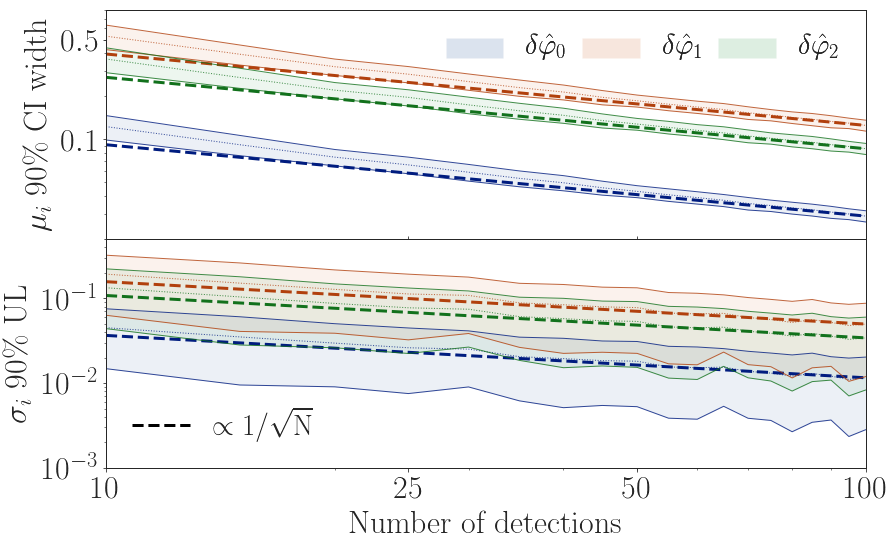

In [39]:
sns.set_palette('deep')

fig, (ax1, ax2) = plt.subplots(2, figsize=fig_size, sharex=True)
fig.subplots_adjust(hspace=0)

anchor_ndet = 100
anchor_idx = np.where(Ndet_plot==anchor_ndet)

c_line = sns.color_palette('dark', nparam)

l_kw = {
    'ls': '--',
    'lw': 3,
}

Ndetx = np.linspace(10, max(Ndet_plot), 200)
for i in range(nparam):
    c = sns.color_palette()[i]
    label = r'$\delta\hat{\varphi}_{%i}$' % i
    #plt.plot(Ndet_plot,np.mean(mu_CI[i],axis=1),label=str(i))
    mu_center = np.mean(mu_CI[i], axis=1)
    mu_bottom = mu_center - np.std(mu_CI[i], axis=1)
    mu_top = mu_center + np.std(mu_CI[i],axis=1)
    ax1.plot(Ndet_plot, mu_center, lw=1, alpha=0.8, ls=':', color=c_line[i])
    ax1.plot(Ndet_plot, mu_bottom, lw=1, alpha=0.8, color=c_line[i])
    ax1.plot(Ndet_plot, mu_top, lw=1, alpha=0.8, color=c_line[i])
    ax1.fill_between(Ndet_plot, mu_bottom, mu_top, label=label, facecolor=c, alpha=0.1)
    # scaling
    scaling_line = mu_center[anchor_idx]/np.sqrt(Ndetx/anchor_ndet)
    ax1.plot(Ndetx, scaling_line, color=c_line[i], **l_kw)
    
    #plt.plot(Ndet_plot,np.mean(sigma_CI[i],axis=1),label=str(i),alpha=0.5)
    sig_center = np.mean(sigma_CI[i], axis=1)
    sig_bottom = sig_center - np.std(sigma_CI[i], axis=1)
    sig_top = sig_center + np.std(sigma_CI[i], axis=1)
    ax2.plot(Ndet_plot, sig_center, lw=1, alpha=0.8, color=c_line[i], ls=':')
    ax2.plot(Ndet_plot, sig_bottom, lw=1, alpha=0.8, color=c_line[i])
    ax2.plot(Ndet_plot, sig_top, lw=1, alpha=0.8, color=c_line[i])
    ax2.fill_between(Ndet_plot, sig_bottom, sig_top, label=label, facecolor=c, alpha=0.1)
    # scaling
    scaling_line = sig_center[anchor_idx]/np.sqrt(Ndetx/anchor_ndet)
    ax2.plot(Ndetx, scaling_line, color=c_line[i], **l_kw) 

    
ax1.tick_params('x', direction='in')
ax2.set_xlabel('Number of detections', fontsize=fs)
ax1.set_ylabel(r'$\mu_i$ 90\% CI width', fontsize=fs)
ax2.set_ylabel('$\sigma_i$ 90\% UL', fontsize=fs)
ax1.set_xlim(min(Ndet_plot), max(Ndet_plot))
ax2.set_xlim(min(Ndet_plot), max(Ndet_plot))

for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')

# labels = [int(l) for l in ax2.get_xticks()][1:-1]
# #     ax2.set_xticklabels(labels)
ax2.set_xticks([10, 25, 50, 100])
from matplotlib.ticker import ScalarFormatter, NullFormatter
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax1.set_ylim(2E-2, 0.8)
ax1.set_yticks([0.1, 0.5])
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax2.set_ylim(1E-3, 5E-1)
# ax1.set_yticks([, 0.5])
# ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# ax2.xaxis.set_major_formatter(ScalarFormatter('%.0f'))
# ax2.set_xticks([int(l) for l in labels])
# ax2.set_xticklabels(labels)
    
l1 = ax1.legend(frameon=False, fontsize=lfs, loc="upper right", ncol=3, columnspacing=0.5)
ax1.add_artist(l1)

from matplotlib.lines import Line2D

l2 = ax2.legend([Line2D([0], [0], c='k', **l_kw)], [r'$\propto1/\sqrt{\mathrm{N}}$'], frameon=False,
                loc='lower left', fontsize=lfs)

plt.show(fig)

fig.savefig("../Paper/fig/GRiscorrect.pdf", bbox_inches='tight')

# Plot (alternative)

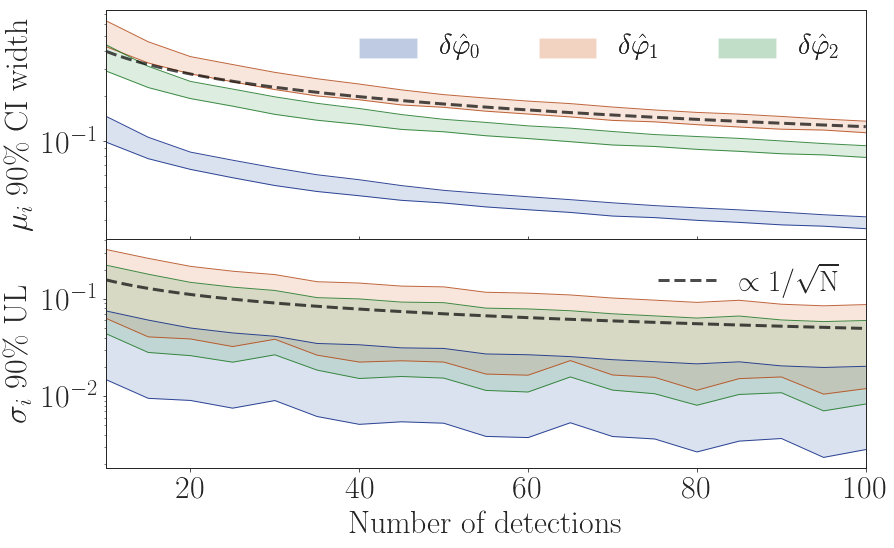

In [38]:
sns.set_palette('deep')

fig, (ax1, ax2) = plt.subplots(2, figsize=fig_size, sharex=True)
fig.subplots_adjust(hspace=0)

anchor_ndet = 100
anchor_idx = np.where(Ndet_plot==anchor_ndet)

c_line = sns.color_palette('dark', nparam)

l_kw = {
    'ls': '--',
    'lw': 3,
    'alpha': 0.7,
}

Ndetx = np.linspace(10, max(Ndet_plot), 200)
for i in range(nparam):
    c = sns.color_palette()[i]
    label = r'$\delta\hat{\varphi}_{%i}$' % i
    #plt.plot(Ndet_plot,np.mean(mu_CI[i],axis=1),label=str(i))
    mu_bottom = np.mean(mu_CI[i], axis=1) - np.std(mu_CI[i], axis=1)
    mu_top = np.mean(mu_CI[i], axis=1) + np.std(mu_CI[i],axis=1)
    ax1.fill_between(Ndet_plot, mu_bottom, mu_top, label=label, facecolor=c, alpha=0.2)
    scaling_line = np.mean(mu_CI[i], axis=1)[anchor_idx]/np.sqrt(Ndetx/anchor_ndet)
#     ax1.plot(Ndetx, scaling_line, color=c_line[i], **l_kw)
    ax1.plot(Ndet_plot, mu_bottom, lw=1, alpha=0.8, color=c_line[i])
    ax1.plot(Ndet_plot, mu_top, lw=1, alpha=0.8, color=c_line[i])
    
    #plt.plot(Ndet_plot,np.mean(sigma_CI[i],axis=1),label=str(i),alpha=0.5)
    sig_bottom = np.mean(sigma_CI[i], axis=1) - np.std(sigma_CI[i], axis=1)
    sig_top = np.mean(sigma_CI[i], axis=1) + np.std(sigma_CI[i], axis=1)
    ax2.fill_between(Ndet_plot, sig_bottom, sig_top, label=label, facecolor=c, alpha=0.2)
#     ax2.plot(Ndetx, np.mean(sigma_CI[i], axis=1)[anchor_idx]/np.sqrt(Ndetx/anchor_ndet),
#              color=c_line[i], **l_kw) 
    ax2.plot(Ndet_plot, sig_bottom, lw=1, alpha=0.8, color=c_line[i])
    ax2.plot(Ndet_plot, sig_top, lw=1, alpha=0.8, color=c_line[i])

scaling_line = np.mean(mu_CI[1], axis=1)[anchor_idx]/np.sqrt(Ndetx/anchor_ndet)
ax1.plot(Ndetx, scaling_line, color='k', **l_kw)
ax2.plot(Ndetx, np.mean(sigma_CI[1], axis=1)[anchor_idx]/np.sqrt(Ndetx/anchor_ndet),
         color='k', **l_kw)
    
ax1.tick_params('x', direction='in')
ax2.set_xlabel('Number of detections', fontsize=fs)
ax1.set_ylabel(r'$\mu_i$ 90\% CI width', fontsize=fs)
ax2.set_ylabel('$\sigma_i$ 90\% UL', fontsize=fs)
ax1.set_xlim(min(Ndet_plot), max(Ndet_plot))
ax2.set_xlim(min(Ndet_plot), max(Ndet_plot))

for ax in [ax1, ax2]:
#     ax.set_xscale('log')
    ax.set_yscale('log')

l1 = ax1.legend(frameon=False, fontsize=lfs, loc="upper right", ncol=3)
ax1.add_artist(l1)

from matplotlib.lines import Line2D

l2 = ax2.legend([Line2D([0], [0], c='k', **l_kw)], [r'$\propto1/\sqrt{\mathrm{N}}$'], frameon=False,
                loc='upper right', fontsize=lfs)

plt.show(fig)

fig.savefig("../Paper/fig/GRiscorrect2.pdf", bbox_inches='tight')